In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook as tqdm

import torch
import re
from torch.utils.data import Dataset, DataLoader
from transformers import ElectraTokenizer, ElectraForSequenceClassification
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import AdamW
import torch.optim as optim

from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
import torch.nn as nn

import warnings
warnings.filterwarnings("ignore")

In [4]:
def set_seed(seed=42):
    np.random.seed(seed)  # 이 부분이 pandas의 sample 함수에도 영향을 줍니다.
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed()

In [5]:
# GPU 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [6]:
# 데이터 로드 및 분할
df = pd.read_csv("/content/gdrive/MyDrive/BOAZ/mini_pj/df_calculation.txt", delimiter=',')
df = df[['wav_id', 'text', 'label']]
df_train, df_test = train_test_split(df, test_size=0.2, shuffle=True, random_state=32)

print(f"Train set size: {len(df_train)}, Test set size: {len(df_test)}")

Train set size: 12370, Test set size: 3093


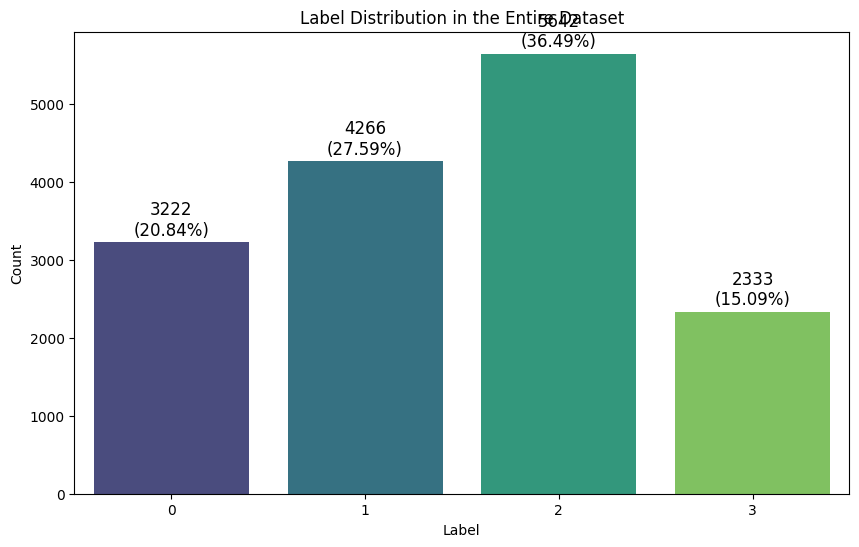

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# 레이블 개수 및 비율 계산
label_counts = df['label'].value_counts()
label_percent = df['label'].value_counts(normalize=True) * 100

# 막대 그래프 그리기
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=label_counts.index, y=label_counts, palette='viridis')

# 그래프에 각각의 개수 표시
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{int(height)}\n({height/len(df)*100:.2f}%)',
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='baseline', fontsize=12, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.title("Label Distribution in the Entire Dataset")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()


In [8]:
df_train.head()

,wav_id,text,label
7290,5f9380c7d338b948c4e6aa17,나 너무 우울해.,2
10301,5fb4cdcb576e9378b67ac08a,어. 우울하고 답답해.,2
1107,5f5c5d8b2e23c7161accd00c,정말 너무 기분이 좋더라고. 내가 이 맛을 보려고 열심히 최선을 다한 것 같아.,1
10921,5fb87c634c55eb78bd7cdc77,나 오늘 짭새 구경하다왔어.,3
9033,5f9228099e04b149046cdc09,단톡방에서 아는 지인이 주식을 추천해줬어.,2


In [9]:
df['label'].unique()

array([1, 2, 0, 3])

In [10]:
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

# Custom Dataset 정의
class KoreanTextDataset(Dataset):
    def __init__(self, df, tokenizer, max_len, with_labels=True):
        self.tokenizer = tokenizer
        self.data = df
        self.sentences = df["text"].values
        self.labels = df["label"].values if with_labels else None
        self.max_len = max_len
        self.with_labels = with_labels

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, index):
        sentence = self.sentences[index]

        inputs = self.tokenizer.encode_plus(
            sentence,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_attention_mask=True,
            truncation=True
        )

        ids = torch.tensor(inputs['input_ids'], dtype=torch.long)
        mask = torch.tensor(inputs['attention_mask'], dtype=torch.long)

        if self.with_labels:
            label = self.labels[index]
            return {
                'ids': ids,
                'mask': mask,
                'labels': torch.tensor(label, dtype=torch.long)
            }
        else:
            return {
                'ids': ids,
                'mask': mask
            }


In [11]:
7# 모델 및 토크나이저 불러오기
koelectra_tokenizer = ElectraTokenizer.from_pretrained("monologg/koelectra-base-discriminator")
koelectra_model = ElectraForSequenceClassification.from_pretrained("monologg/koelectra-base-discriminator", num_labels=4).to(device)

tokenizer_config.json:   0%|          | 0.00/51.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/279k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/467 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/443M [00:00<?, ?B/s]

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at monologg/koelectra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
# 모델 학습 함수
def train_model(model, tokenizer, train_dataframe, epochs, epochs_stop):
    BATCH_SIZE = 16
    MAX_LEN = 256

    # Train-validation split
    train_df, val_df = train_test_split(train_dataframe, test_size=0.2, random_state=42)

    # Datasets and DataLoaders
    train_data = KoreanTextDataset(train_df, tokenizer, MAX_LEN)
    val_data = KoreanTextDataset(val_df, tokenizer, MAX_LEN)
    train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
    val_dataloader = DataLoader(val_data, batch_size=BATCH_SIZE)

    # Optimizer, loss function, and learning rate scheduler
    optimizer = AdamW(model.parameters(), lr=2e-5)
    criterion = nn.CrossEntropyLoss()
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.9, patience=5, verbose=True)

    model.train()
    no_improve = 0
    prev_loss = float('inf')

    for epoch in range(epochs):
        running_loss = 0.0
        running_acc = 0.0  # Accuracy tracking
        model.train()

        for step, data in enumerate(train_dataloader):
            ids = data['ids'].to(device)
            mask = data['mask'].to(device)
            labels = data['labels'].to(device)

            outputs = model(ids, attention_mask=mask)
            loss = criterion(outputs.logits, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            running_acc += calc_accuracy(outputs.logits, labels)  # Accuracy 계산

        # Validation
        model.eval()
        val_loss = 0.0
        val_acc = 0.0  # Validation accuracy tracking

        with torch.no_grad():
            for data in val_dataloader:
                ids = data['ids'].to(device)
                mask = data['mask'].to(device)
                labels = data['labels'].to(device)

                outputs = model(ids, attention_mask=mask)
                loss = criterion(outputs.logits, labels)
                val_loss += loss.item()
                val_acc += calc_accuracy(outputs.logits, labels)  # Validation accuracy 계산

        avg_train_loss = running_loss / len(train_dataloader)
        avg_val_loss = val_loss / len(val_dataloader)
        avg_train_acc = running_acc / len(train_dataloader)
        avg_val_acc = val_acc / len(val_dataloader)

        print(f"EPOCH {epoch+1} completed: Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}, Training Accuracy: {avg_train_acc:.4f}, Validation Accuracy: {avg_val_acc:.4f}")

        # Learning rate scheduler step
        scheduler.step(avg_val_loss)

        # Early stopping check
        if prev_loss - avg_val_loss <= 0.0001:
            no_improve += 1
        else:
            no_improve = 0

        prev_loss = avg_val_loss

        if no_improve == epochs_stop:
            print("Early stopping due to no improvement in validation loss.")
            break

    return model

In [13]:
# Accuracy 계산 함수
def calc_accuracy(preds, labels):
    _, max_indices = torch.max(preds, dim=1)
    accuracy = (max_indices == labels).sum().item() / max_indices.size(0)
    return accuracy

In [14]:
# 모델 학습 실행
koelectra_model_trained = train_model(koelectra_model, koelectra_tokenizer, df_train, epochs=10, epochs_stop=5)

EPOCH 1 completed: Training Loss: 0.9100, Validation Loss: 0.7554, Training Accuracy: 0.6316, Validation Accuracy: 0.6986
EPOCH 2 completed: Training Loss: 0.6752, Validation Loss: 0.7315, Training Accuracy: 0.7436, Validation Accuracy: 0.7156
EPOCH 3 completed: Training Loss: 0.5624, Validation Loss: 0.7627, Training Accuracy: 0.7930, Validation Accuracy: 0.7206
EPOCH 4 completed: Training Loss: 0.4529, Validation Loss: 0.8750, Training Accuracy: 0.8389, Validation Accuracy: 0.7156
EPOCH 5 completed: Training Loss: 0.3704, Validation Loss: 0.9316, Training Accuracy: 0.8719, Validation Accuracy: 0.7000
EPOCH 6 completed: Training Loss: 0.3122, Validation Loss: 0.9984, Training Accuracy: 0.8927, Validation Accuracy: 0.6957
EPOCH 7 completed: Training Loss: 0.2551, Validation Loss: 1.2189, Training Accuracy: 0.9122, Validation Accuracy: 0.6960
Early stopping due to no improvement in validation loss.


In [15]:
def evaluate_model(model, tokenizer, test_dataframe, batch_size=16, max_len=256):
    model.eval()
    test_data = KoreanTextDataset(test_dataframe, tokenizer, max_len)
    test_dataloader = DataLoader(test_data, batch_size=batch_size)

    test_acc = 0.0
    with torch.no_grad():
        for data in test_dataloader:
            ids = data['ids'].to(device)
            mask = data['mask'].to(device)
            labels = data['labels'].to(device)

            outputs = model(ids, attention_mask=mask)
            test_acc += calc_accuracy(outputs.logits, labels)

    avg_test_acc = test_acc / len(test_dataloader)
    print(f"Test Accuracy: {avg_test_acc:.4f}")
    return avg_test_acc

In [16]:
# Test 데이터 평가
evaluate_model(koelectra_model_trained, koelectra_tokenizer, df_test)

Test Accuracy: 0.6791


0.6790592783505155

In [17]:
from sklearn.metrics import f1_score

def evaluate_model(model, tokenizer, test_dataframe, batch_size=16, max_len=256):
    model.eval()
    test_data = KoreanTextDataset(test_dataframe, tokenizer, max_len)
    test_dataloader = DataLoader(test_data, batch_size=batch_size)

    test_acc = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for data in test_dataloader:
            ids = data['ids'].to(device)
            mask = data['mask'].to(device)
            labels = data['labels'].to(device)

            outputs = model(ids, attention_mask=mask)
            test_acc += calc_accuracy(outputs.logits, labels)

            # 예측 결과와 실제 라벨을 수집
            preds = torch.argmax(outputs.logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_test_acc = test_acc / len(test_dataloader)

    # F1-Score 계산
    avg_f1_score = f1_score(all_labels, all_preds, average='weighted')  # 'weighted'는 다중 클래스 문제에 유용함

    print(f"Test Accuracy: {avg_test_acc:.4f}")
    print(f"F1-Score: {avg_f1_score:.4f}")

    return avg_test_acc, avg_f1_score

# Test 데이터 평가
evaluate_model(koelectra_model_trained, koelectra_tokenizer, df_test)


Test Accuracy: 0.6791
F1-Score: 0.6646


(0.6790592783505155, 0.6645971621738889)

In [18]:
import numpy as np

# Other imports and code...

# Function to save predictions, actual labels, and logits to .npy files
def save_predictions(all_preds, all_labels, all_logits):
    np.save("text_pred.npy", np.array(all_preds))  # Save predicted labels
    np.save("text_truth.npy", np.array(all_labels))  # Save actual labels
    np.save("text_output.npy", np.array(all_logits))  # Save model logits

# Modified evaluate_model function
def evaluate_model(model, tokenizer, test_dataframe, batch_size=16, max_len=256):
    model.eval()
    test_data = KoreanTextDataset(test_dataframe, tokenizer, max_len)
    test_dataloader = DataLoader(test_data, batch_size=batch_size)

    test_acc = 0.0
    all_preds = []
    all_labels = []
    all_logits = []

    with torch.no_grad():
        for data in test_dataloader:
            ids = data['ids'].to(device)
            mask = data['mask'].to(device)
            labels = data['labels'].to(device)

            outputs = model(ids, attention_mask=mask)
            test_acc += calc_accuracy(outputs.logits, labels)

            # Collect predictions, actual labels, and logits
            preds = torch.argmax(outputs.logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_logits.extend(outputs.logits.cpu().numpy())

    avg_test_acc = test_acc / len(test_dataloader)

    # Calculate F1-Score
    avg_f1_score = f1_score(all_labels, all_preds, average='weighted')

    print(f"Test Accuracy: {avg_test_acc:.4f}")
    print(f"F1-Score: {avg_f1_score:.4f}")

    # Save the results to .npy files
    save_predictions(all_preds, all_labels, all_logits)

    return avg_test_acc, avg_f1_score

# Test 데이터 평가
evaluate_model(koelectra_model_trained, koelectra_tokenizer, df_test)


Test Accuracy: 0.6791
F1-Score: 0.6646


(0.6790592783505155, 0.6645971621738889)

In [20]:
import numpy as np

# Other imports and code...

# Function to save predictions, actual labels, and logits to .npy files in Google Drive
def save_predictions(all_preds, all_labels, all_logits):
    # Define the path to your Google Drive
    drive_path = '/content/gdrive/MyDrive/BOAZ/mini_pj/'  # Change 'YourFolderName' to the desired folder in your Google Drive

    # Save the files to Google Drive
    np.save(drive_path + "text_pred.npy", np.array(all_preds))  # Save predicted labels
    np.save(drive_path + "text_truth.npy", np.array(all_labels))  # Save actual labels
    np.save(drive_path + "text_output.npy", np.array(all_logits))  # Save model logits

# Modified evaluate_model function
def evaluate_model(model, tokenizer, test_dataframe, batch_size=16, max_len=256):
    model.eval()
    test_data = KoreanTextDataset(test_dataframe, tokenizer, max_len)
    test_dataloader = DataLoader(test_data, batch_size=batch_size)

    test_acc = 0.0
    all_preds = []
    all_labels = []
    all_logits = []

    with torch.no_grad():
        for data in test_dataloader:
            ids = data['ids'].to(device)
            mask = data['mask'].to(device)
            labels = data['labels'].to(device)

            outputs = model(ids, attention_mask=mask)
            test_acc += calc_accuracy(outputs.logits, labels)

            # Collect predictions, actual labels, and logits
            preds = torch.argmax(outputs.logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_logits.extend(outputs.logits.cpu().numpy())

    avg_test_acc = test_acc / len(test_dataloader)

    # Calculate F1-Score
    avg_f1_score = f1_score(all_labels, all_preds, average='weighted')

    print(f"Test Accuracy: {avg_test_acc:.4f}")
    print(f"F1-Score: {avg_f1_score:.4f}")

    # Save the results to .npy files in Google Drive
    save_predictions(all_preds, all_labels, all_logits)

    return avg_test_acc, avg_f1_score

# Test 데이터 평가
evaluate_model(koelectra_model_trained, koelectra_tokenizer, df_test)

Test Accuracy: 0.6791
F1-Score: 0.6646


(0.6790592783505155, 0.6645971621738889)